# KE5105 - Building Electrical Consumption Forecasting

# Extract, Transform and Load Data 3 - Data Exploration

## Summary of Findings

* Column names differ by whitespaces and dashes in csv files for some buildings. These need to be removed to merge the date across files (e.g. BTU SDE 2, BTU-SDE2 and PWM SDE 2 SSB, PWM-SDE2 SSB)
* Many buildings have intermittent zero values in their cumulative PWM readings (see analysis below).

## Load libraries

In [1]:
%matplotlib inline

import myUtilities as myUtils
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import random

## Load Data

In [4]:
RAW_DATA_PATH = "source/105 building data"
COMBINED_DATA_PATH = "source/combined_bldg_data"

# This function combines all the raw time series PWM data in separate csv files into one csv file for a building.
# It also performs date/time and string to numeric conversions.
def combine_csv_files_by_bldg(name, input_data_path=RAW_DATA_PATH, output_data_path=COMBINED_DATA_PATH):

    bldg_data_list = myUtils._load_data_by_bldg_(name, input_data_path)

    # Convert the date/time for all the dataframes in the list.
    for i in bldg_data_list:
        if not i[3].empty:
            if myUtils.is_day_first(i[0], i[3])[0]:
                i[3].loc[:, 'Pt_timeStamp'] = pd.to_datetime(i[3].loc[:, 'Pt_timeStamp'], dayfirst=True)
            else:
                i[3].loc[:, 'Pt_timeStamp'] = pd.to_datetime(i[3].loc[:, 'Pt_timeStamp'])

    # Convert the strings to floats for all the dataframes in the list.
    for i in bldg_data_list:
        if not i[3].empty:
            for j in i[3].iloc[:, 1:].columns:
                i[3][j] = i[3][j].astype('str').apply(lambda x: x.replace(',', '')).astype('float')

    # Concatenate the list of dataframes into 1 single dataframe.
    df_list = []
    for i in bldg_data_list:
        df_list.append(i[3])
    bldg_data_df = pd.concat(df_list)

    # Reindex the dataframe using the year/month/day/time, add missing values for any period with no files.
    bldg_data_df.set_index('Pt_timeStamp', inplace=True)
    all_dates = pd.date_range('5/2015', '8/2018', freq='30min')
    bldg_data_df = bldg_data_df.reindex(all_dates)
    bldg_data_df.sort_index(inplace=True)

    # Copy index (i.e. Pt_timeStamp) back to a column
    bldg_data_df.insert(0, 'Pt_timeStamp', bldg_data_df.index)
    bldg_data_df.reset_index(drop=True, inplace=True)

    # Save the dataframe as csv file. Do not write row names (i.e. index 0,1,2,3,4,...)
    bldg_data_df.to_csv(output_data_path + '/' + name + '.csv', index=False)

    return None

In [6]:
## Combine the csv files for the building into 1 file.
combine_csv_files_by_bldg('SDE-2')

In [7]:
# Read the csv file.
sde2_df = pd.read_csv('source/combined_bldg_data/SDE-2-old.csv', index_col=0, parse_dates=True)

## Explore the Data

In [8]:
# From 1 May 2015 (including) to 1 Aug 2018 (not including), there are 1188 days (ref planetcalc.com). Total number of observations = 1188 x 48 + 1 = 57025.
sde2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57025 entries, 2015-05-01 00:00:00 to 2018-08-01 00:00:00
Data columns (total 6 columns):
BTU SDE 2        882 non-null float64
BTU-SDE2         40412 non-null float64
PWM SDE 2 AC     882 non-null float64
PWM SDE 2 MSB    882 non-null float64
PWM SDE 2 SSB    882 non-null float64
PWM-SDE2 SSB     40412 non-null float64
dtypes: float64(6)
memory usage: 3.0 MB


In [9]:
sde2_df.iloc[:5, :]

,BTU SDE 2,BTU-SDE2,PWM SDE 2 AC,PWM SDE 2 MSB,PWM SDE 2 SSB,PWM-SDE2 SSB
Pt_timeStamp,,,,,,
2015-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
sde2_df.iloc[len(sde2_df)-5:, :]

,BTU SDE 2,BTU-SDE2,PWM SDE 2 AC,PWM SDE 2 MSB,PWM SDE 2 SSB,PWM-SDE2 SSB
Pt_timeStamp,,,,,,
2018-07-31 22:00:00,NaN,1170972.13,NaN,NaN,NaN,3499722.75
2018-07-31 22:30:00,NaN,1170972.13,NaN,NaN,NaN,3499737.75
2018-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


BTU SDE 2, BTU-SDE2 and PWM SDE 2 SSB, PWM-SDE2 SSB look like the same columns. We need to remove **whitespaces** and **dashes** to correctly concatenate the csv files (i.e. merge the columns).

In [11]:
sde2_PWM_columns = []
for i in sde2_df.columns:
    if 'PWM' in i:
        sde2_PWM_columns.append(i)
sde2_PWM_columns

['PWM SDE 2 AC', 'PWM SDE 2 MSB', 'PWM SDE 2 SSB', 'PWM-SDE2 SSB']

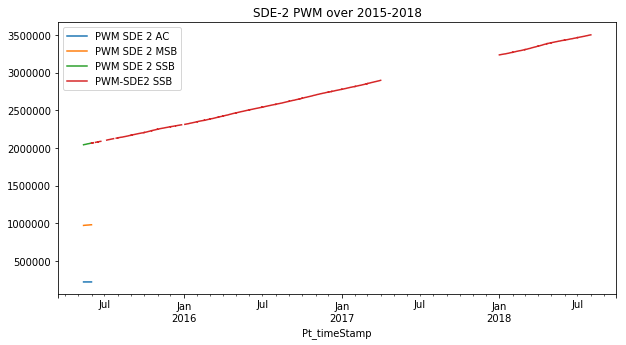

In [13]:
sde2_df.loc[:, sde2_PWM_columns].plot(figsize=(10, 5), title='SDE-2 PWM over 2015-2018')

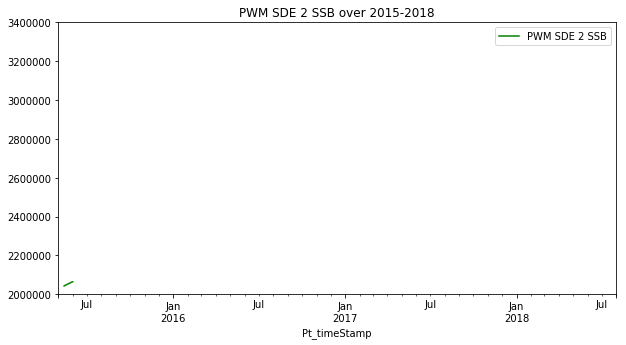

In [14]:
sde2_df['PWM SDE 2 SSB'].plot(figsize=(10, 5), title='PWM SDE 2 SSB over 2015-2018', xlim=['2015-05-01 00H', '2018-08-01 00H'],
                              ylim=[2000000, 3400000], legend=True, color='green')

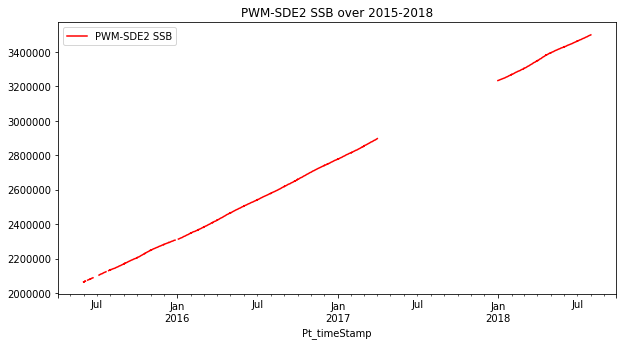

In [15]:
sde2_df['PWM-SDE2 SSB'].plot(figsize=(10, 5), title='PWM-SDE2 SSB over 2015-2018', legend=True, color='red')

In [16]:
# Merge the columns 'PWM SDE 2 SSB' and 'PWM-SDE2 SSB'.
sde2_df['PWMSDE2SSB'] = sde2_df.apply(lambda x: x[4] if math.isnan(x[5]) else x[5], axis=1)
sde2_df['PWMSDE2SSB'].head()

Pt_timeStamp
2015-05-01 00:00:00   NaN
2015-05-01 00:30:00   NaN
2015-05-01 01:00:00   NaN
2015-05-01 01:30:00   NaN
2015-05-01 02:00:00   NaN
Name: PWMSDE2SSB, dtype: float64

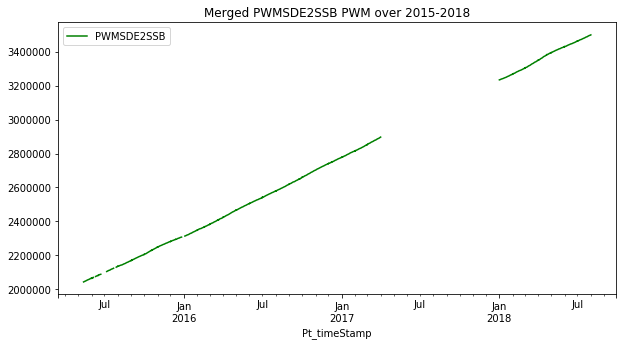

In [17]:
sde2_df['PWMSDE2SSB'].plot(figsize=(10, 5), title='Merged PWMSDE2SSB PWM over 2015-2018', legend=True, color='green')

## Reload the New Pre-processed Data for SDE-2

The re-indexing to fill in missing time periods will not be done in the pre-processing. There is no way to figure out from the data which months are missing before and after the time period range in the data. It is better to do this in the context of each analysis which should be for a specified time period. For each analysis, the data re-indexing can be done after reading the data from file based on the analysis period.

In [18]:
# Combine the csv files for the building into 1 file with all the required pre-processing.
myUtils.combine_csv_files_by_bldg('SDE-2')

In [7]:
# Read the csv file.
new_sde2_list = myUtils.load_data_by_bldg(['SDE-2'], 'combined')

In [5]:
new_sde2_list[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41298 entries, 2018-05-01 00:00:00 to 2016-02-29 22:30:00
Data columns (total 4 columns):
BTUSDE2       41298 non-null float64
PWMSDE2AC     882 non-null float64
PWMSDE2MSB    882 non-null float64
PWMSDE2SSB    41298 non-null float64
dtypes: float64(4)
memory usage: 1.6 MB


In [16]:
new_sde2_list[0][1].head()

,BTUSDE2,PWMSDE2AC,PWMSDE2MSB,PWMSDE2SSB
Pt_timeStamp,,,,
2018-05-01 00:00:00,1123082.88,NaN,NaN,3394773.50
2018-05-01 00:30:00,1123082.88,NaN,NaN,3394784.75
2018-05-01 01:00:00,1123083.75,NaN,NaN,3394795.50
2018-05-01 01:30:00,1123084.00,NaN,NaN,3394805.50
2018-05-01 02:00:00,1123084.25,NaN,NaN,3394816.00


In [9]:
sde2_PWM_columns = []
for i in new_sde2_list[0][1].columns:
    if 'PWM' in i:
        sde2_PWM_columns.append(i)
sde2_PWM_columns

['PWMSDE2AC', 'PWMSDE2MSB', 'PWMSDE2SSB']

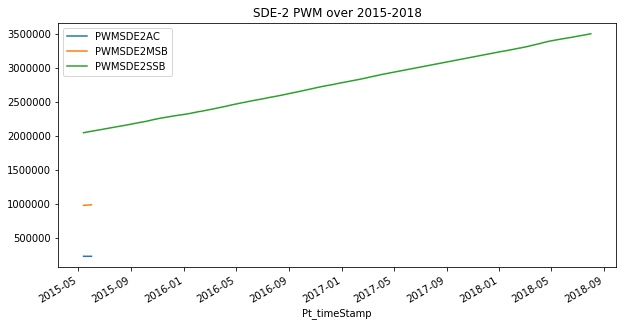

In [10]:
new_sde2_list[0][1].loc[:, sde2_PWM_columns].plot(figsize=(10, 5), title='SDE-2 PWM over 2015-2018')

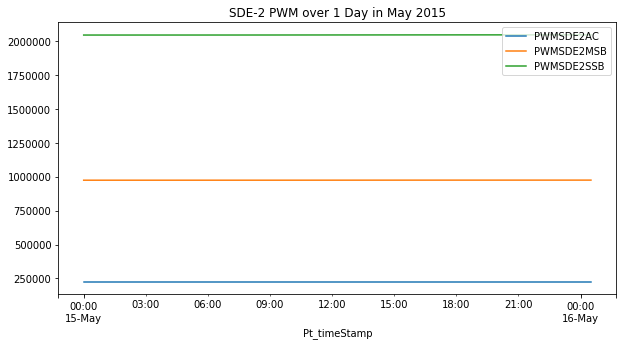

In [11]:
new_sde2_list[0][1].loc['2015-05-15 00H':'2015-05-16 00H', sde2_PWM_columns].plot(figsize=(10, 5), title='SDE-2 PWM over 1 Day in May 2015')

The PWM aggregation formula for SDE-2 has only 1 reading which should be PWMSDE2SSB. The readings for PWMSDE2AC and PWMSDE2MSB can be discarded.

## Load the Pre-processed Data for All the Group 1 Buildings

In [2]:
to_load_file = open('source/combined_bldg_data/group1_bldg_list.pickle', 'rb')
group1_bldgs = pickle.load(to_load_file)
group1_bldgs.sort()
group1_bldgs

['AS4', 'AS5', 'CELS', 'E4', 'EA', 'MRB', 'S1A', 'SDE-1', 'SDE-2', 'SDE-3']

In [21]:
# Combine the csv files for each group 1 building into 1 file with all the required pre-processing.
for i in group1_bldgs:
    myUtils.combine_csv_files_by_bldg(i)

In [24]:
# Load the combined building data.
gp1_bldg_df_list = myUtils.load_data_by_bldg(group1_bldgs, type='combined')

In [26]:
# Reindex the group 1 building data by filling in any missing periods before plotting.
for idx, a_bldg in enumerate(gp1_bldg_df_list):

    #Get the min, max month/year
    start = a_bldg[1].index.min().strftime('%m/%Y')
    end = a_bldg[1].index.max().strftime('%m/%Y')
    print(start, end)

    # Reindex
    gp1_bldg_df_list[idx] = [a_bldg[0], myUtils.reindex_ts_df(a_bldg[1], start, end)]

06/2015 07/2018
06/2015 07/2018
06/2015 07/2018
05/2015 07/2018
05/2015 07/2018
06/2015 07/2018
06/2015 07/2018
05/2015 07/2018
05/2015 07/2018
06/2015 07/2018


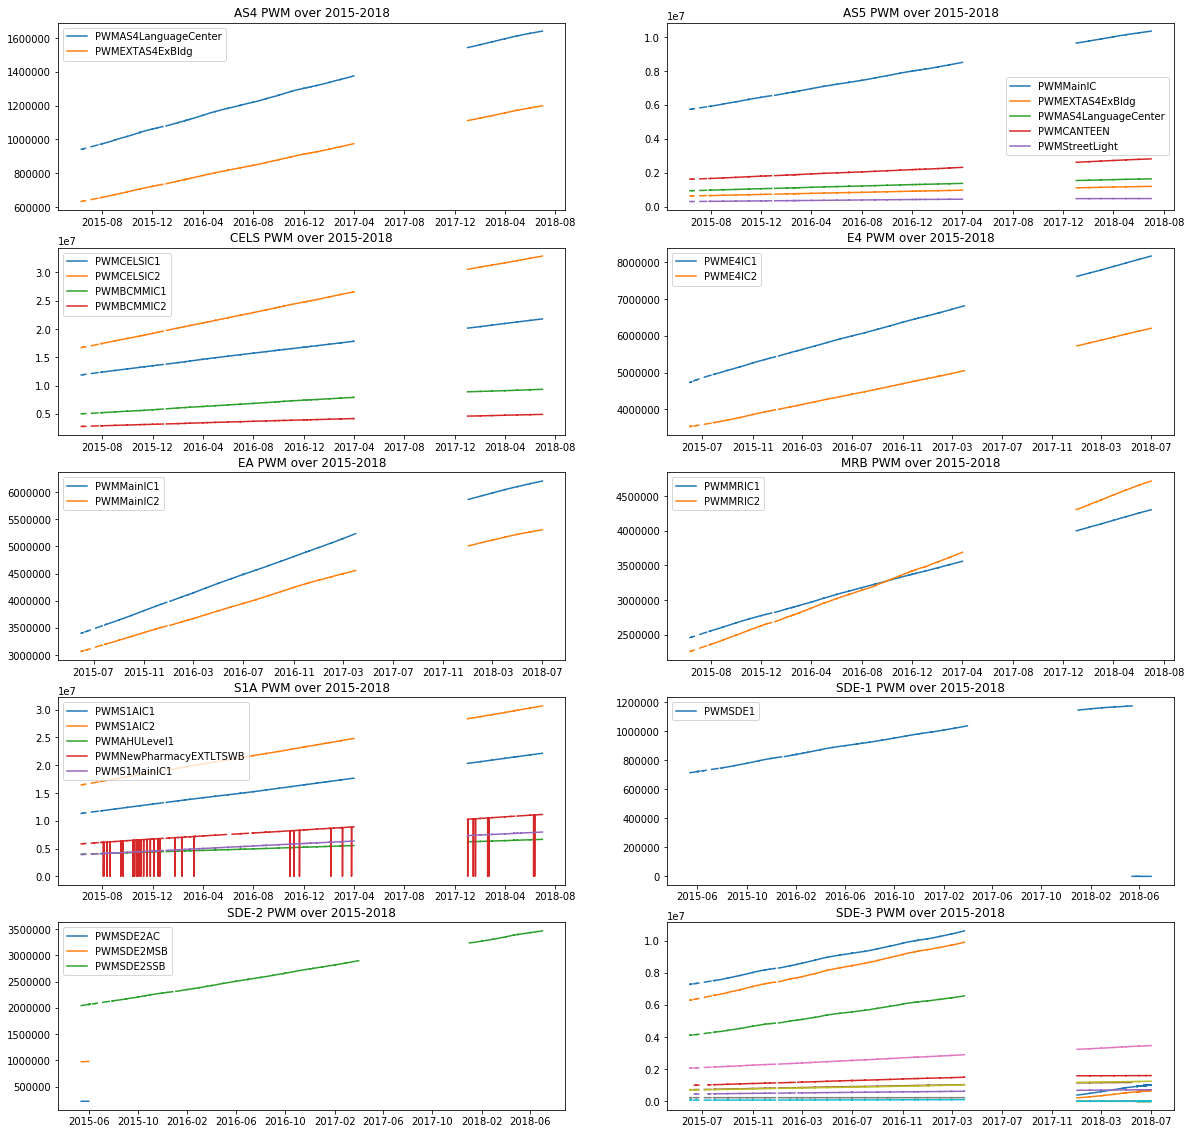

In [27]:
# Plot the cumulative PWM for all the group 1 buildings.
myUtils.plot_pwm_upto10_bldgs(gp1_bldg_df_list)

Note that in building S1A, the PWM for the New Pharmacy EXTLT has **intermittent zero values**.

## Load the Pre-processed Data for All the Group 2 Buildings

In [3]:
to_load_file = open('source/combined_bldg_data/group2_bldg_list.pickle', 'rb')
group2_bldgs = pickle.load(to_load_file)
group2_bldgs.sort()
group2_bldgs[:10]

['AS1',
 'AS2',
 'AS3',
 'AS6',
 'AS7',
 'AS8',
 'Alumni House',
 'BIZ 2',
 'Block B',
 'Brenner Center of Molecular Medicine']

In [30]:
len(group2_bldgs)

95

In [26]:
# Combine the csv files for each group 2 building into 1 file with all the required pre-processing.
for i in group2_bldgs:
    myUtils.combine_csv_files_by_bldg(i)

In [31]:
group2_bldgs.index('S1')

64

In [32]:
group2_bldgs[60:70]

['RC4',
 'Raffles Hall',
 'Ridge View',
 'Ridge View Residence',
 'S1',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14']

In [33]:
s10_list = myUtils.load_data_by_bldg(['S10'], 'combined')
s10_list[0][1].head()

,PWMMDB1S10Level1,PWMMDB1S10Level2,BTUS10AHUL1,BTUS10AHUL2
Pt_timeStamp,,,,
2018-05-01 01:30:00,NaN,NaN,159427.84,130156.32
2018-05-01 02:00:00,NaN,NaN,159427.84,130156.32
2018-05-01 02:30:00,NaN,NaN,159427.84,130156.32
2018-05-01 03:00:00,NaN,NaN,159427.84,130156.32
2018-05-01 03:30:00,NaN,NaN,159427.84,130156.32


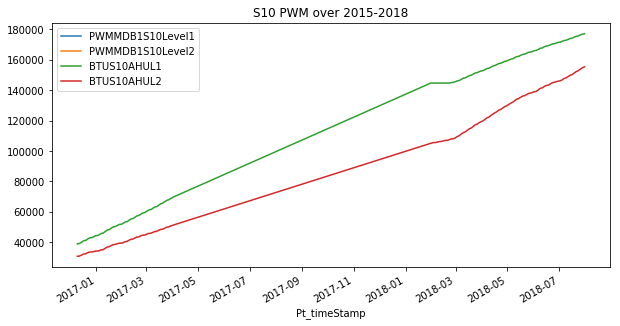

In [34]:
s10_list[0][1].plot(figsize=(10, 5), title='S10 PWM over 2015-2018')

In [40]:
bldg_sample_list = random.sample(group2_bldgs, 10)
bldg_sample_list

['S1',
 'S7',
 'Central Library',
 'S5',
 'RC4',
 'Alumni House',
 'EW2',
 'MD6',
 'ETS Building',
 'S13']

In [41]:
# Load the combined building data.
sample_bldg_df_list = myUtils.load_data_by_bldg(bldg_sample_list, type='combined')

In [42]:
# Reindex the group 2 sample building data by filling in any missing periods before plotting.
for idx, a_bldg in enumerate(sample_bldg_df_list):

    #Get the min, max month/year
    start = a_bldg[1].index.min().strftime('%m/%Y')
    end = a_bldg[1].index.max().strftime('%m/%Y')
    print(start, end)

    # Reindex
    sample_bldg_df_list[idx] = [a_bldg[0], myUtils.reindex_ts_df(a_bldg[1], start, end)]

12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018


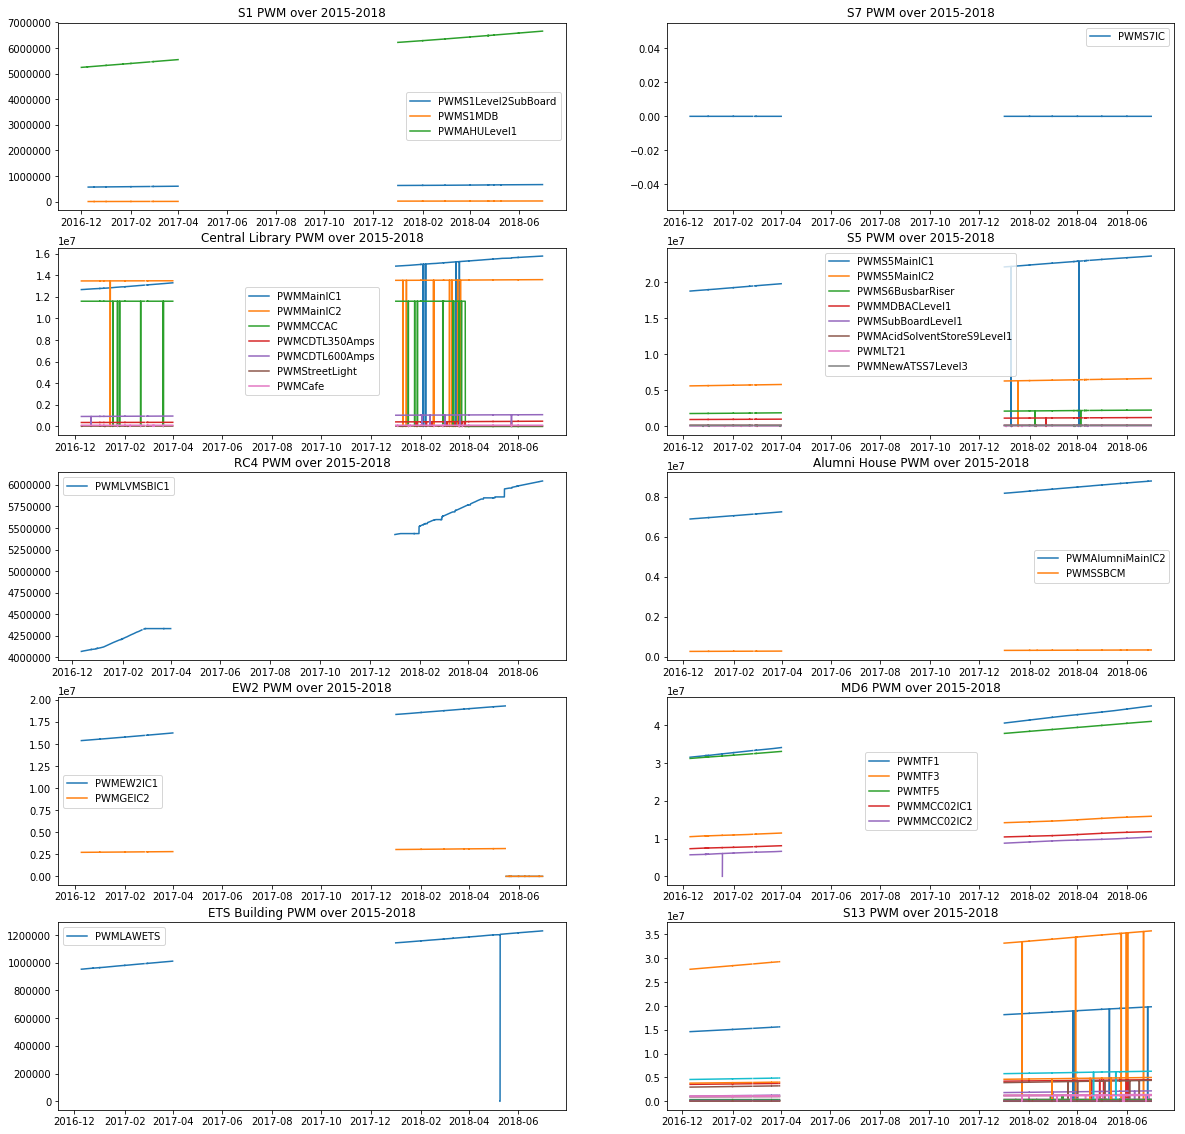

In [43]:
myUtils.plot_pwm_upto10_bldgs(sample_bldg_df_list)

Many buildings have intermittent zero values in their cumulative PWM readings.

In [6]:
# Check the message log file.
messages = myUtils.read_msg_log()
print(messages)

None


12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018
12/2016 07/2018


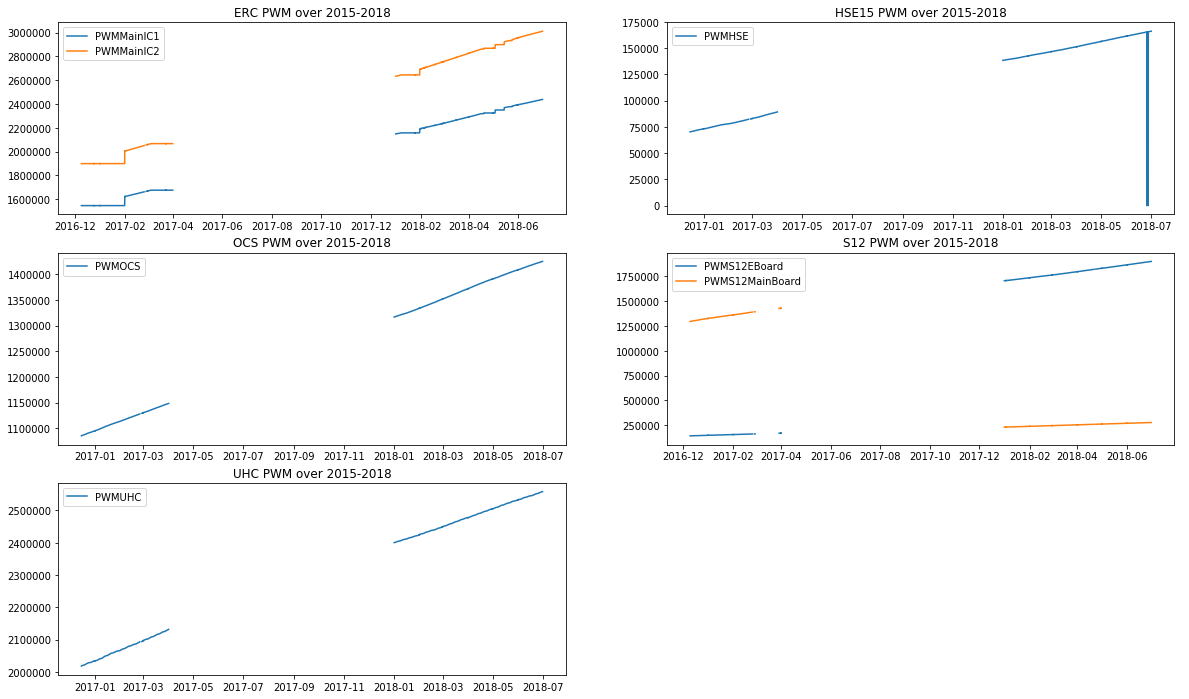

In [7]:
another_sample_df_list = myUtils.load_data_by_bldg(['ERC','HSE15', 'OCS', 'S12', 'UHC'], type='combined')
# Reindex the building data by filling in any missing periods before plotting.
for idx, a_bldg in enumerate(another_sample_df_list):
    #Get the min, max month/year
    start = a_bldg[1].index.min().strftime('%m/%Y')
    end = a_bldg[1].index.max().strftime('%m/%Y')
    print(start, end)
    # Reindex
    another_sample_df_list[idx] = [a_bldg[0], myUtils.reindex_ts_df(a_bldg[1], start, end)]
myUtils.plot_pwm_upto10_bldgs(another_sample_df_list)